#Priyesh
#NUID: 001094740
#**Problem 3**

Preprocessing

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import ssl

C:\Users\amarp\.conda\envs\MLClass\lib\site-packages\huggingface_hub\utils\_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


In [5]:

ssl._create_default_https_context = ssl._create_unverified_context

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
classes = ('plane', 'car')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# select two classes for train dataset
selected_trn_idx = []
for i in range(2):
  trainset_idx = [idx for idx, data in enumerate(trainset) if data[1] == i]
  selected_trn_idx.extend(trainset_idx)
  print(f'class {i} : {len(trainset_idx)}')
trainset = Subset(trainset, selected_trn_idx)


class 0 : 5000
class 1 : 5000


In [7]:
# select two classes for test dataset
selected_test_idx = []
for i in range(2):
  testset_indices = [idx for idx, data in enumerate(testset) if data[1] == i]
  selected_test_idx.extend(testset_indices)
  print(f'class {i} : {len(testset_indices)}')
testset = Subset(testset, selected_test_idx)
len(testset)

class 0 : 1000
class 1 : 1000


2000

In [8]:
# setup dataloader
batch_size = 4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


**3A**<br>
Implement a two-layer neural network with a nonlinear ReLU activation function.<br>

In [7]:
import torch.nn as nn
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class FcNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, nonlinear = True):
        super(FcNet, self).__init__()
        self.fully_connected_layer_1 = nn.Linear(input_size, hidden_size)
        self.activation_function_relu = nn.ReLU()
        self.fully_connected_layer_2 = nn.Linear(hidden_size, num_classes)
        self.nonLinear = nonlinear




    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.fully_connected_layer_1(x)
        if self.nonLinear:
            out = self.activation_function_relu(out)
        out = self.fully_connected_layer_2(out)
        return out


input_dimension =3 * 32 * 32
hidden_layer_size =100
num_classes =2  # SInce there are two classes

#Initialize the model
net =  FcNet(input_dimension, hidden_layer_size, num_classes )
print("Structure of Neural network")
net




Structure of Neural network


FcNet(
  (fully_connected_layer_1): Linear(in_features=3072, out_features=100, bias=True)
  (activation_function_relu): ReLU()
  (fully_connected_layer_2): Linear(in_features=100, out_features=2, bias=True)
)

In [8]:
from torch import optim


# TODO: Implement loss and optimizer for FcNet
#--------------------------
#Defining loss criterion
criterion = nn.CrossEntropyLoss()

# TODO: Define your optimizer
# For example, you can use stochastic gradient descent (SGD) with a specific learning rate
#Defining optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001)


**3B**<br>
Implement the training and test procedure for learning the parameters of the
neural network. Plot the training accuracy curve, test accuracy curve, training loss curve,
and test loss curve as the number of epochs increases.

In [6]:

from torch import optim

def train(epoch, model, cNN = False):

    model.to(device)
    training_accuracy = []
    testing_accuracy = []
    training_loss = []
    testing_loss = []
    optimizer = optim.SGD(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epoch):
        print(f"Epoch= {epoch}")

        model.train()

        running_loss_train = 0.0
        loss_per_batch = 0.0
        for i, data in enumerate(trainloader, 0):

            inputs, labels = data
            if not cNN:
                inputs = inputs.view(inputs.size(0), -1)
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss_train += loss.item()
            loss_per_batch += loss.item()

            if i % 1000 == 999:

                print(f'[{epoch + 1}, {i + 1:5d}] loss per 1000 batches Train: {loss_per_batch / 1000:.3f}')
                loss_per_batch = 0.0


        model.eval()

        print("Training Loss and Accuracy")

        train_loss = running_loss_train / len(trainloader)
        train_accuracy = predict(model=model,data_loader=trainloader, cNN = cNN)
        training_loss.append(train_loss)
        training_accuracy.append(train_accuracy)

        print("")

        running_loss_test = 0.0
        loss_per_batch = 0.0

        with torch.no_grad():
            for i, data in enumerate(testloader, 0):
                inputs, labels = data

                if not cNN:
                    inputs = inputs.view(inputs.size(0), -1) # Flatten the images
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss_test += loss.item()
                loss_per_batch += loss.item()

                if i % 240 == 239:

                    print(f'[{epoch + 1}, {i + 1:5d}] loss per 240 batches Test: {loss_per_batch / 240:.3f}')
                    loss_per_batch = 0.0

        print("Test Loss and Accuracy")

        test_loss = running_loss_test / len(testloader)
        test_accuracy = predict(model=model, data_loader=testloader,cNN = cNN)
        testing_loss.append(test_loss)
        testing_accuracy.append(test_accuracy)
        print("")



    print('Finished Training')
    return training_accuracy, testing_accuracy, training_loss, testing_loss


def predictTest(model,cNN = False):
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}
  # again no gradients needed
  with torch.no_grad():
      for data in testloader:

          images, labels = data
          images, labels = images.to(device), labels.to(device)
          if not cNN:
              images = images.view(images.size(0), -1)


          outputs = model(images)

          _, predictions = torch.max(outputs, 1)






        # TODO: Implement predict loop


          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1


  # print accuracy for each class
  for classname, correct_count in correct_pred.items():
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

  # print overall accuracy:
  # print(np.sum(list(correct_pred.values())), np.sum(list(total_pred.values())))
  all_accuracy = 100 * np.sum(list(correct_pred.values())) / np.sum(list(total_pred.values()))
  print(f'Accuracy for all: {all_accuracy:.1f} %')
  return all_accuracy


def predict(model, data_loader ,cNN = False):
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}
  correct_images = []
  incorrect_images = []
  # again no gradients needed
  with torch.no_grad():
      for data in data_loader:

          images, labels = data
          images, labels = images.to(device), labels.to(device)
          if not cNN:
              images = images.view(images.size(0), -1)

          outputs = model(images)
          print(outputs)
          print("------------")
          _, predictions = torch.max(outputs, 1)

          print(predictions)

          print("------------")
          print(labels)

          for [label, prediction] in list(zip(labels, predictions)):
              if label == prediction:
                  correct_pred[classes[label]] += 1

              else:



              total_pred[classes[label]] += 1


  # print accuracy for each class
  for classname, correct_count in correct_pred.items():
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

  # print overall accuracy:
  # print(np.sum(list(correct_pred.values())), np.sum(list(total_pred.values())))
  all_accuracy = 100 * np.sum(list(correct_pred.values())) / np.sum(list(total_pred.values()))
  print(f'Accuracy for all: {all_accuracy:.1f} %')
  return all_accuracy

In [18]:
net =  FcNet(input_dimension, hidden_layer_size, num_classes)
training_accuracy, testing_accuracy, training_loss, testing_loss = train(epoch=10, model=net)

Epoch= 0
[1,  1000] loss per 1000 batches Train: 0.520
[1,  2000] loss per 1000 batches Train: 0.431
Training Loss and Accuracy
tensor([[ 0.1736,  0.0743],
        [ 1.3109, -1.3776],
        [-0.7115,  0.9377],
        [-0.0121, -0.3835]], device='cuda:0')
------------
tensor([0, 0, 1, 0], device='cuda:0')
------------
tensor([0, 0, 1, 1], device='cuda:0')
tensor([[-0.5255,  0.6478],
        [-1.9567,  2.4333],
        [ 0.4778, -0.3464],
        [-2.3150,  2.4887]], device='cuda:0')
------------
tensor([1, 1, 0, 1], device='cuda:0')
------------
tensor([0, 1, 1, 1], device='cuda:0')
tensor([[ 0.3615, -0.1373],
        [ 0.2333, -0.4087],
        [-0.2099,  0.2601],
        [-1.0918,  1.2445]], device='cuda:0')
------------
tensor([0, 0, 1, 1], device='cuda:0')
------------
tensor([0, 0, 0, 1], device='cuda:0')
tensor([[ 0.4959, -0.3543],
        [-0.0260,  0.1873],
        [-0.5713,  0.7768],
        [-0.5499,  0.6311]], device='cuda:0')
------------
tensor([0, 1, 1, 1], device='cuda

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002668C55A440>
Traceback (most recent call last):
  File "C:\Users\amarp\.conda\envs\MLClass\lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "C:\Users\amarp\.conda\envs\MLClass\lib\site-packages\torch\utils\data\dataloader.py", line 1436, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


KeyboardInterrupt: 

Stats for two-layer neural network with a nonlinear ReLU activation Function


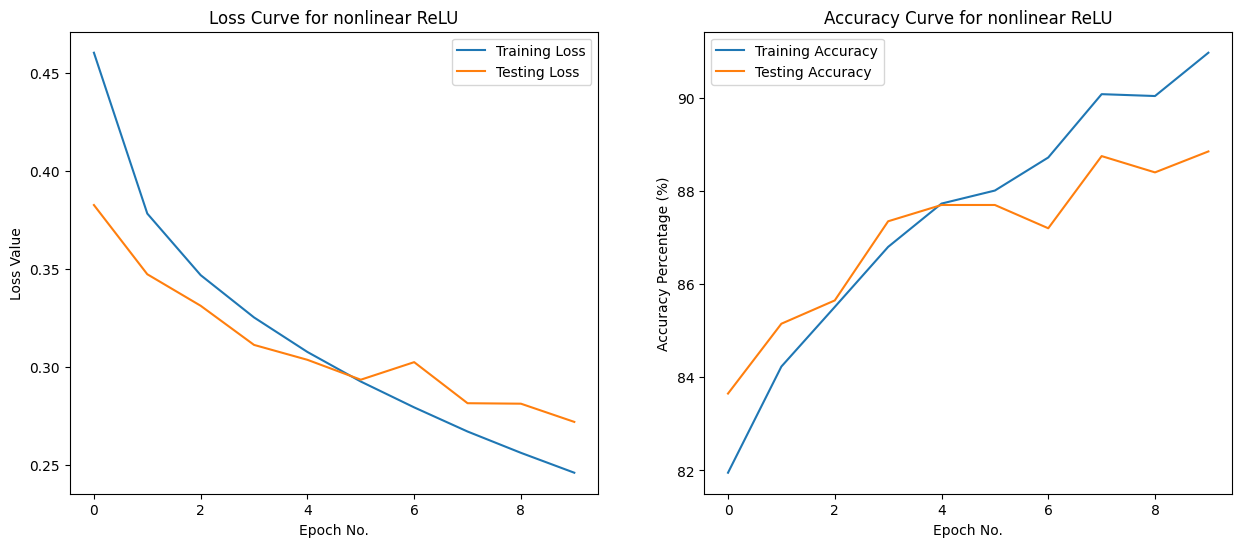

In [150]:
import matplotlib.pyplot as plt

print("Stats for two-layer neural network with a nonlinear ReLU activation Function")
plt.figure(figsize=(15, 6))

# Training and Test Loss
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(testing_loss, label='Testing Loss')
plt.title('Loss Curve for nonlinear ReLU')
plt.xlabel('Epoch No.')
plt.ylabel('Loss Value')
plt.legend()

# Training and Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(testing_accuracy, label='Testing Accuracy')
plt.title('Accuracy Curve for nonlinear ReLU')
plt.xlabel('Epoch No.')
plt.ylabel('Accuracy Percentage (%)')
plt.legend()

plt.show()


**3C**<br>
Two-layer neural network without the nonlinear ReLU

In [151]:

net =  FcNet(input_dimension, hidden_layer_size, num_classes,nonlinear=False)
training_accuracy, testing_accuracy, training_loss, testing_loss = train(epoch=10,model=net)


Epoch= 0
[1,  1000] loss per 1000 batches Train: 0.500
[1,  2000] loss per 1000 batches Train: 0.426
Training Loss and Accuracy
Accuracy for class: plane is 77.6 %
Accuracy for class: car   is 85.1 %
Accuracy for all: 81.4 %

[1,   240] loss per 240 batches Test: 0.435
[1,   480] loss per 240 batches Test: 0.373
Test Loss and Accuracy
Accuracy for class: plane is 80.8 %
Accuracy for class: car   is 84.4 %
Accuracy for all: 82.6 %

Epoch= 1
[2,  1000] loss per 1000 batches Train: 0.421
[2,  2000] loss per 1000 batches Train: 0.418
Training Loss and Accuracy
Accuracy for class: plane is 79.8 %
Accuracy for class: car   is 84.5 %
Accuracy for all: 82.2 %

[2,   240] loss per 240 batches Test: 0.408
[2,   480] loss per 240 batches Test: 0.374
Test Loss and Accuracy
Accuracy for class: plane is 82.2 %
Accuracy for class: car   is 83.8 %
Accuracy for all: 83.0 %

Epoch= 2
[3,  1000] loss per 1000 batches Train: 0.406
[3,  2000] loss per 1000 batches Train: 0.417
Training Loss and Accuracy
Ac

Stats for Two-layer neural network without the nonlinear ReLU


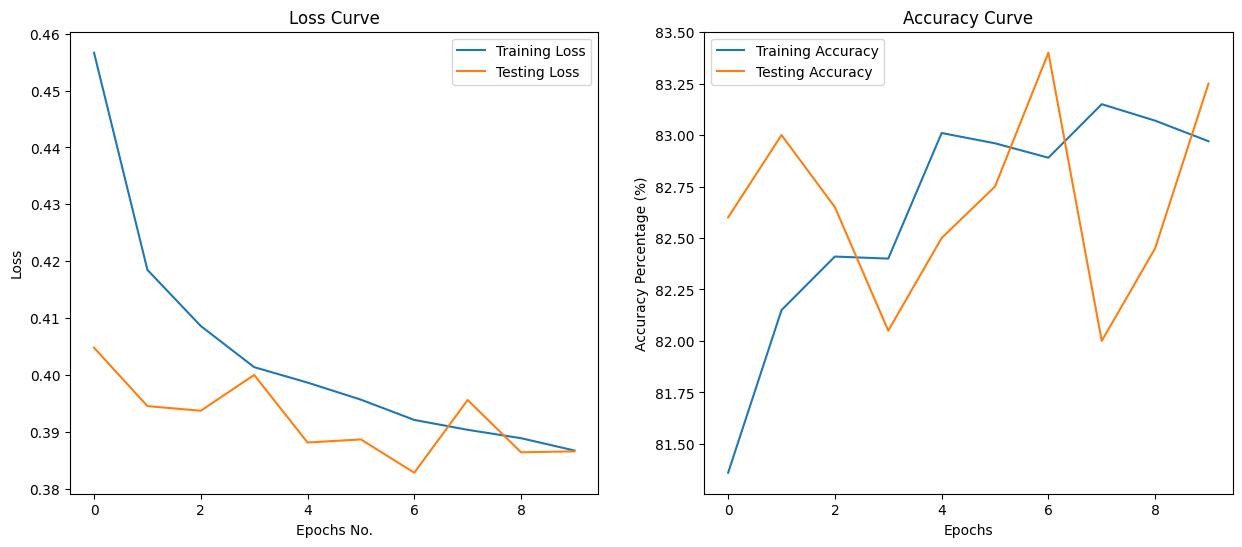

In [152]:

import matplotlib.pyplot as plt

print("Stats for Two-layer neural network without the nonlinear ReLU")
plt.figure(figsize=(15, 6))


plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(testing_loss, label='Testing Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs No.')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(testing_accuracy, label='Testing Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Percentage (%)')
plt.legend()

plt.show()



**3D**<br>
Now, set up a convolutional neural network to solve this problem.<br>

In [153]:
class CovNet(nn.Module):
    def __init__(self, num_classes = 2):

        super(CovNet, self).__init__()
        # self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        # self.relu = nn.ReLU()
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        # self.fc = nn.Linear(32 * 8 * 8, num_classes)

        self.convolution1_2d = nn.Conv2d(3, 12, kernel_size=3, stride=1, padding=1)
        self.relu_activation_function = nn.ReLU()
        self.pooling_layer = nn.MaxPool2d(kernel_size=2, stride=2)
        self.convolution2_2d = nn.Conv2d(12, 24, kernel_size=3, stride=1, padding=1)
        self.fully_connected_layer = nn.Linear(1536, num_classes)


    def forward(self, x):
        x = self.convolution1_2d(x)
        x = self.pooling_layer(x)
        x = self.convolution2_2d(x)
        #x = self.pooling_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fully_connected_layer(x)
        return x


        #
        # x = self.pool(self.relu(self.conv1(x)))
        # x = self.pool(self.relu(self.conv2(x)))
        # #x = self.avgpool(x)  # Apply global average pooling
        # x = x.view(x.size(0), -1)  # Flatten
        # x = self.fc(x)
        # return x



In [165]:
convolutedNN = CovNet()
training_accuracy_convolutedNN, testing_accuracy_convolutedNN, training_loss, testing_loss = train(epoch=10,model=convolutedNN,cNN = True)


Epoch= 0
[1,  1000] loss per 1000 batches Train: 0.538
[1,  2000] loss per 1000 batches Train: 0.464
Training Loss and Accuracy
Accuracy for class: plane is 77.1 %
Accuracy for class: car   is 87.0 %
Accuracy for all: 82.1 %

[1,   240] loss per 240 batches Test: 0.417
[1,   480] loss per 240 batches Test: 0.365
Test Loss and Accuracy
Accuracy for class: plane is 81.4 %
Accuracy for class: car   is 86.7 %
Accuracy for all: 84.0 %

Epoch= 1
[2,  1000] loss per 1000 batches Train: 0.393
[2,  2000] loss per 1000 batches Train: 0.381
Training Loss and Accuracy
Accuracy for class: plane is 84.0 %
Accuracy for class: car   is 86.1 %
Accuracy for all: 85.0 %

[2,   240] loss per 240 batches Test: 0.316
[2,   480] loss per 240 batches Test: 0.346
Test Loss and Accuracy
Accuracy for class: plane is 85.4 %
Accuracy for class: car   is 85.3 %
Accuracy for all: 85.3 %

Epoch= 2
[3,  1000] loss per 1000 batches Train: 0.344
[3,  2000] loss per 1000 batches Train: 0.338
Training Loss and Accuracy
Ac

**3E**<br>
Report the training and test accuracies from running the CNN.

Training accuracy of convolutedNN = 90.16
Test accuracy of convolutedNN = 90.05
Stats for Convoluted Neural Network


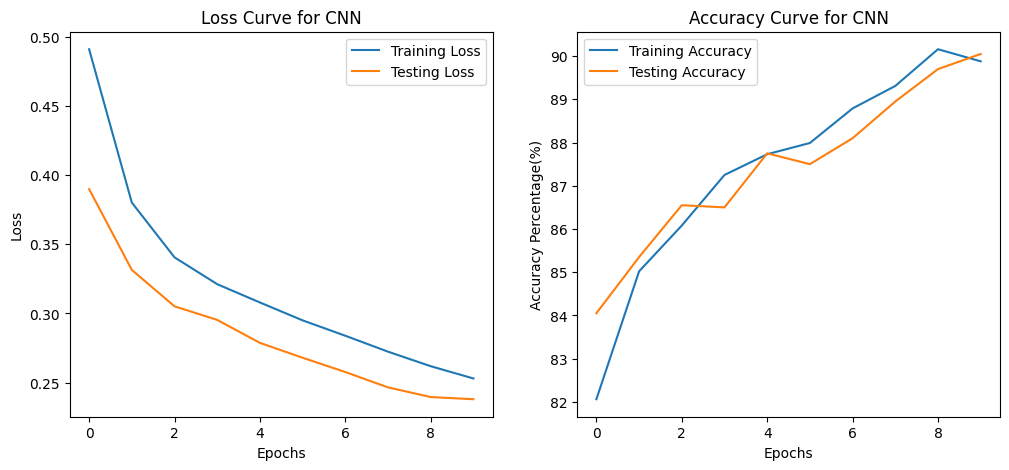

In [166]:
print(f"Training accuracy of convolutedNN = {max(training_accuracy_convolutedNN)}" )
print(f"Test accuracy of convolutedNN = {max(testing_accuracy_convolutedNN)}" )
plt.figure(figsize=(12, 5))

print("Stats for Convoluted Neural Network")

plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(testing_loss, label='Testing Loss')
plt.title('Loss Curve for CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training and Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy_convolutedNN, label='Training Accuracy')
plt.plot(testing_accuracy_convolutedNN, label='Testing Accuracy')
plt.title('Accuracy Curve for CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Percentage(%)')
plt.legend()

plt.show()


**3F**<br>
Compare the number of parameters used between fully-connected and convolutional
networks.

In [156]:

class FullyConnectedModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(FullyConnectedModel, self).__init__()
        self.fc1 = nn.Linear(input_size, input_size)
        self.fc2 = nn.Linear(input_size, num_classes)


    def forward(self, x):
        x = self.fc1(x)
        x = x.view(x.size(0), -1)
        x = self.fc2(x)
        return x

# Instantiate the fully connected model
input_size_fc =  3 * 32 * 32
num_classes = 2  # Assuming 10 classes for classification


In [157]:
fc_model = FullyConnectedModel(input_size_fc, num_classes)
training_accuracy_fc_model, testing_accuracy_fc_model, training_loss, testing_loss = train(epoch=6,model=fc_model,cNN=False)



Epoch= 0
[1,  1000] loss per 1000 batches Train: 0.475
[1,  2000] loss per 1000 batches Train: 0.437
Training Loss and Accuracy
Accuracy for class: plane is 74.7 %
Accuracy for class: car   is 86.6 %
Accuracy for all: 80.7 %

[1,   240] loss per 240 batches Test: 0.474
[1,   480] loss per 240 batches Test: 0.336
Test Loss and Accuracy
Accuracy for class: plane is 78.7 %
Accuracy for class: car   is 86.6 %
Accuracy for all: 82.7 %

Epoch= 1
[2,  1000] loss per 1000 batches Train: 0.405
[2,  2000] loss per 1000 batches Train: 0.424
Training Loss and Accuracy
Accuracy for class: plane is 83.1 %
Accuracy for class: car   is 81.5 %
Accuracy for all: 82.3 %

[2,   240] loss per 240 batches Test: 0.367
[2,   480] loss per 240 batches Test: 0.418
Test Loss and Accuracy
Accuracy for class: plane is 84.6 %
Accuracy for class: car   is 79.7 %
Accuracy for all: 82.2 %

Epoch= 2
[3,  1000] loss per 1000 batches Train: 0.412
[3,  2000] loss per 1000 batches Train: 0.395
Training Loss and Accuracy
Ac

In [158]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())
num_params_fc = count_parameters(fc_model)
num_params_cnn = count_parameters(convolutedNN)

print(f"Number of parameters in Fully Connected Model: {num_params_fc}")
print(f"Number of parameters in CNN Model: {num_params_cnn}")
print(f"Test Accuracy of CNN: {max(testing_accuracy_convolutedNN)}")
print(f"Test Accuracy of FUlly Connected Neural Network: {max(testing_accuracy_fc_model)}")

Number of parameters in Fully Connected Model: 9446402
Number of parameters in CNN Model: 6026
Test Accuracy of CNN: 89.75
Test Accuracy of FUlly Connected Neural Network: 83.2


CNNs has convolutional layers connecting neurons to a local region in the input data. This enables sharing of params in different regions, leading to reduction in over all parameters for CNN.
In contrast, fully connected neural Network has layers having connections between every neuron in one layer to every neuron in the next layer, resulting in a larger number of parameters.

As seen from above: Test Accracy for convoluted neural network is greater than test accuracy for fully connected NN as  the structural advantages of CNNs make them more suitable for image processing tasks, often resulting in higher test accuracy compared to FCNNs, especially on complex image datasets.

Stats for fully-connected NN


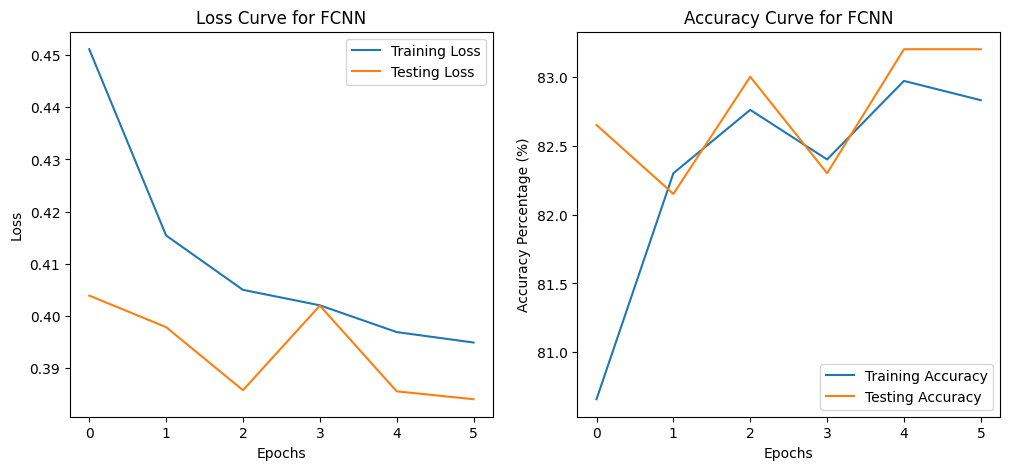

In [159]:

plt.figure(figsize=(12, 5))

print("Stats for fully-connected NN")
# Training and Test Loss
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(testing_loss, label='Testing Loss')
plt.title('Loss Curve for FCNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training and Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy_fc_model, label='Training Accuracy')
plt.plot(testing_accuracy_fc_model, label='Testing Accuracy')
plt.title('Accuracy Curve for FCNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Percentage (%)')
plt.legend()

plt.show()


**3G**
Lastly, consider using transfer learning using a pretrained
convolutional neural network to solve this problem.

In [9]:

from torch import optim

def train(epoch, model, cNN = False):

    model.to(device)
    training_accuracy = []
    testing_accuracy = []
    training_loss = []
    testing_loss = []
    optimizer = optim.SGD(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epoch):
        print(f"Epoch= {epoch}")

        model.train()

        running_loss_train = 0.0
        loss_per_batch = 0.0
        for i, data in enumerate(trainloader, 0):

            inputs, labels = data
            if not cNN:
                inputs = inputs.view(inputs.size(0), -1)
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss_train += loss.item()
            loss_per_batch += loss.item()

            if i % 1000 == 999:

                print(f'[{epoch + 1}, {i + 1:5d}] loss per 1000 batches Train: {loss_per_batch / 1000:.3f}')
                loss_per_batch = 0.0


        model.eval()

        print("Training Loss and Accuracy")

        train_loss = running_loss_train / len(trainloader)
        train_accuracy = predict(model=model,data_loader=trainloader, cNN = cNN)
        training_loss.append(train_loss)
        training_accuracy.append(train_accuracy)

        print("")

        running_loss_test = 0.0
        loss_per_batch = 0.0

        with torch.no_grad():
            for i, data in enumerate(testloader, 0):
                inputs, labels = data

                if not cNN:
                    inputs = inputs.view(inputs.size(0), -1) # Flatten the images
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss_test += loss.item()
                loss_per_batch += loss.item()

                if i % 240 == 239:

                    print(f'[{epoch + 1}, {i + 1:5d}] loss per 240 batches Test: {loss_per_batch / 240:.3f}')
                    loss_per_batch = 0.0

        print("Test Loss and Accuracy")

        test_loss = running_loss_test / len(testloader)
        test_accuracy= predict(model=model, data_loader=testloader,cNN = cNN)
        testing_loss.append(test_loss)
        testing_accuracy.append(test_accuracy)
        print("")



    print('Finished Training')
    return training_accuracy, testing_accuracy, training_loss, testing_loss


def predictTest(model,cNN = False):
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}
  # again no gradients needed
  with torch.no_grad():
      for data in testloader:

          images, labels = data
          images, labels = images.to(device), labels.to(device)
          if not cNN:
              images = images.view(images.size(0), -1)


          outputs = model(images)

          _, predictions = torch.max(outputs, 1)






        # TODO: Implement predict loop


          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1


  # print accuracy for each class
  for classname, correct_count in correct_pred.items():
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

  # print overall accuracy:
  # print(np.sum(list(correct_pred.values())), np.sum(list(total_pred.values())))
  all_accuracy = 100 * np.sum(list(correct_pred.values())) / np.sum(list(total_pred.values()))
  print(f'Accuracy for all: {all_accuracy:.1f} %')
  return all_accuracy


def predict(model, data_loader ,cNN = False):
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}
  correct_images = []
  incorrect_images = []
  # again no gradients needed
  with torch.no_grad():
      for data in data_loader:

          images, labels = data
          images, labels = images.to(device), labels.to(device)
          if not cNN:
              images = images.view(images.size(0), -1)

          outputs = model(images)
          print(outputs)
          print("------------")
          _, predictions = torch.max(outputs, 1)

          print(predictions)

          print("------------")
          print(labels)

          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1




              total_pred[classes[label]] += 1


  # print accuracy for each class
  for classname, correct_count in correct_pred.items():
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

  # print overall accuracy:
  # print(np.sum(list(correct_pred.values())), np.sum(list(total_pred.values())))
  all_accuracy = 100 * np.sum(list(correct_pred.values())) / np.sum(list(total_pred.values()))
  print(f'Accuracy for all: {all_accuracy:.1f} %')
  return all_accuracy


def predictTestNew(model, data_loader ,cNN = False):
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}
  correct_images = []
  incorrect_images = []
  # again no gradients needed
  with torch.no_grad():
      for data in data_loader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          if not cNN:
              images = images.view(images.size(0), -1)

          outputs = model(images)
          print(outputs)
          print("------------")
          _, predictions = torch.max(outputs, 1)

          print(predictions)

          print("------------")
          print(labels)

          for [label, prediction],i in enumerate(list(zip(labels, predictions))):
              if label == prediction:
                  correct_pred[classes[label]] += 1
                  correct_images.append([images[i], label])
              else:
                  incorrect_images.append([images[i], label])


              total_pred[classes[label]] += 1


  # print accuracy for each class
  for classname, correct_count in correct_pred.items():
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

  # print overall accuracy:
  # print(np.sum(list(correct_pred.values())), np.sum(list(total_pred.values())))
  all_accuracy = 100 * np.sum(list(correct_pred.values())) / np.sum(list(total_pred.values()))
  print(f'Accuracy for all: {all_accuracy:.1f} %')
  return all_accuracy,incorrect_images,correct_images

In [10]:

import torchvision.models as models
import torch.nn as nn


resnet18 = models.resnet18(pretrained=True)


for param in resnet18.parameters():
    param.requires_grad = False


num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)


C:\Users\amarp\.conda\envs\MLClass\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\amarp\.conda\envs\MLClass\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
# Unfreezing all layers
for param in resnet18.parameters():
    param.requires_grad = True




In [12]:
training_accuracy, testing_accuracy, training_loss, testing_loss = train(epoch=1,model=resnet18, cNN=True)

Epoch= 0
[1,  1000] loss per 1000 batches Train: 0.439
[1,  2000] loss per 1000 batches Train: 0.424
Training Loss and Accuracy
tensor([[ 1.0887, -0.2332],
        [-0.2745,  0.2586],
        [ 2.2722,  0.3585],
        [-0.8720,  2.1294]], device='cuda:0')
------------
tensor([0, 1, 0, 1], device='cuda:0')
------------
tensor([0, 0, 0, 1], device='cuda:0')
tensor([[-0.5809,  1.4181],
        [ 2.0297, -0.4580],
        [ 1.5032, -1.1256],
        [-0.8554,  0.1471]], device='cuda:0')
------------
tensor([1, 0, 0, 1], device='cuda:0')
------------
tensor([1, 0, 0, 1], device='cuda:0')
tensor([[ 3.3863, -1.0403],
        [ 0.0530,  0.3332],
        [-0.7848, -0.6978],
        [ 1.3746, -1.5642]], device='cuda:0')
------------
tensor([0, 1, 1, 0], device='cuda:0')
------------
tensor([0, 0, 0, 0], device='cuda:0')
tensor([[-1.5018,  2.4275],
        [-0.3291,  1.0033],
        [ 0.6075,  1.5448],
        [ 1.7849,  0.3775]], device='cuda:0')
------------
tensor([1, 1, 1, 0], device='cuda

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

print(f'max test accuracy: {max(testing_accuracy)}')
print(f'max train accuracy: {max(training_accuracy)}')
print("Stats for Pretrained NN resnet18")
# Training and Test Loss
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Train Loss')
plt.plot(testing_loss, label='Test Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training and Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Train Accuracy')
plt.plot(testing_accuracy, label='Test Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()



max test accuracy: 86.8
max train accuracy: 87.52
Stats for Pretrained NN resnet18


In [13]:
def predictTestNew(model, data_loader ,cNN = False):
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}
  correct_images = []
  incorrect_images = []
  # again no gradients needed
  with torch.no_grad():
      for data in data_loader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          if not cNN:
              images = images.view(images.size(0), -1)

          outputs = model(images)
          print(outputs)
          print("------------")
          _, predictions = torch.max(outputs, 1)

          print(predictions)

          print("------------")
          print(labels)

          for i,[label, prediction], in enumerate((zip(labels, predictions))):
              if label == prediction:
                  correct_pred[classes[label]] += 1
                  correct_images.append([images[i], label])
              else:
                  incorrect_images.append([images[i], label])


              total_pred[classes[label]] += 1


  # print accuracy for each class
  for classname, correct_count in correct_pred.items():
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

  # print overall accuracy:
  # print(np.sum(list(correct_pred.values())), np.sum(list(total_pred.values())))
  all_accuracy = 100 * np.sum(list(correct_pred.values())) / np.sum(list(total_pred.values()))
  print(f'Accuracy for all: {all_accuracy:.1f} %')
  return all_accuracy,incorrect_images,correct_images
acc, incorrect, correct = predictTestNew(model=resnet18, data_loader=testloader, cNN=True)

tensor([[ 1.9586, -1.9245],
        [ 0.9844,  0.2460],
        [ 2.3670,  0.5669],
        [ 7.3625, -4.0764]], device='cuda:0')
------------
tensor([0, 0, 0, 0], device='cuda:0')
------------
tensor([0, 0, 0, 0], device='cuda:0')
tensor([[ 0.7989, -0.2231],
        [ 1.7731, -0.5750],
        [-0.7134,  1.1915],
        [ 0.4856, -1.3864]], device='cuda:0')
------------
tensor([0, 0, 1, 0], device='cuda:0')
------------
tensor([0, 0, 0, 0], device='cuda:0')
tensor([[ 3.8086, -1.8183],
        [ 6.6291, -3.5551],
        [-0.0102, -0.3772],
        [ 3.5108, -3.9908]], device='cuda:0')
------------
tensor([0, 0, 0, 0], device='cuda:0')
------------
tensor([0, 0, 0, 0], device='cuda:0')
tensor([[ 1.1010, -0.4323],
        [ 0.9443,  0.0248],
        [ 2.8787,  0.6240],
        [ 2.5981, -2.0462]], device='cuda:0')
------------
tensor([0, 0, 0, 0], device='cuda:0')
------------
tensor([0, 0, 0, 0], device='cuda:0')
tensor([[ 0.6039, -0.8441],
        [ 1.9481,  0.2962],
        [ 1.6479

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

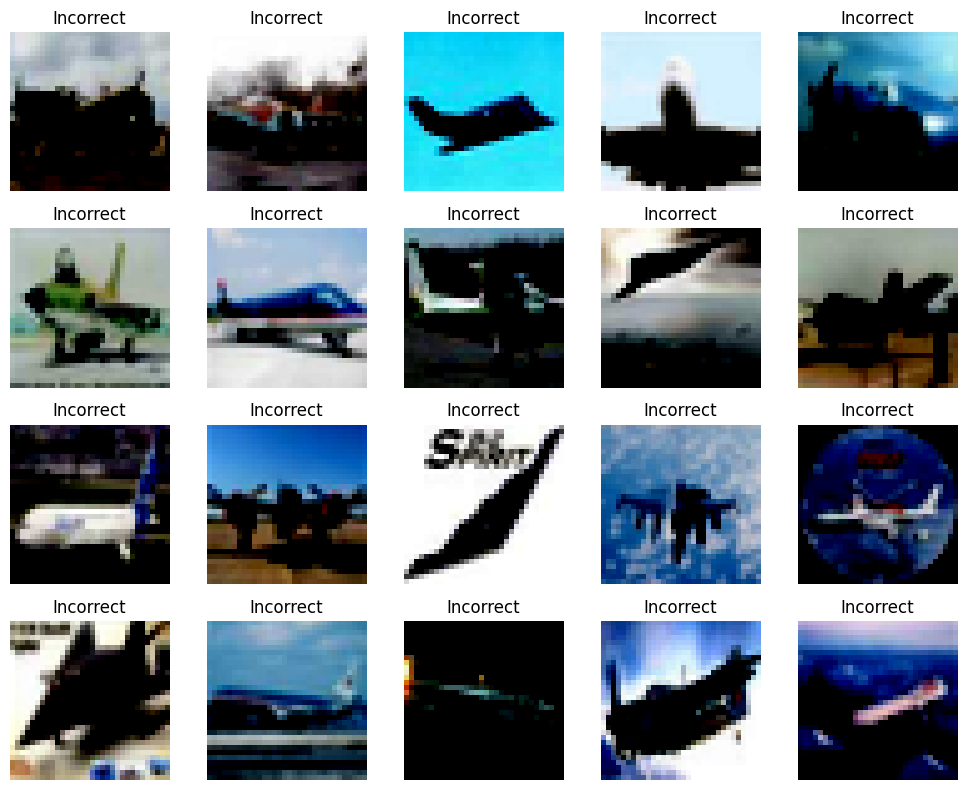

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming incorrect is a list of 3D tensors
# Replace this with your actual data

# Plot 20 incorrect images along the depth dimension
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 8))


for ax, k in zip(axes.flatten(), incorrect):
    # Choose the depth dimension to plot (change axis as needed)
    ax.imshow(k[0].cpu().permute(1, 2, 0).numpy())  # Permute the dimensions for proper display

    # Customize the plot appearance
    ax.set_title('Plane')
    ax.axis('off')
    ax.grid(True)

plt.tight_layout()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

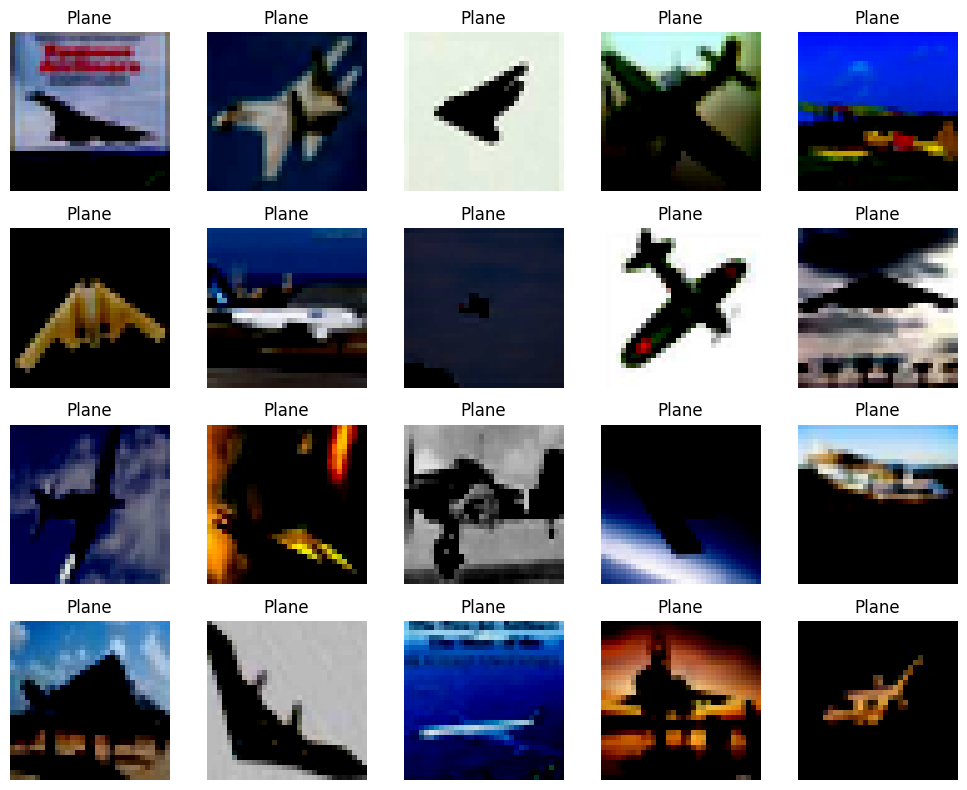

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming incorrect is a list of 3D tensors
# Replace this with your actual data

# Plot 20 incorrect images along the depth dimension
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 8))


for ax, k in zip(axes.flatten(), correct):
    # Choose the depth dimension to plot (change axis as needed)
    ax.imshow(k[0].cpu().permute(1, 2, 0).numpy())  # Permute the dimensions for proper display

    # Customize the plot appearance
    ax.set_title('Plane')
    ax.axis('off')
    ax.grid(True)

plt.tight_layout()
plt.show()


In [164]:

def count_parameters1(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
num_params_fc = count_parameters1(fc_model)
num_params_cnn = count_parameters1(convolutedNN)
resnet18_param = count_parameters1(resnet18)

print(f"Number of parameters in Fully Connected Model: {num_params_fc}")
print(f"Number of parameters in CNN Model: {num_params_cnn}")
print(f"Number of parameters in resnet18 Model: {resnet18_param}")

Number of parameters in Fully Connected Model: 9446402
Number of parameters in CNN Model: 6026
Number of parameters in resnet18 Model: 11177538


In [ ]:
Number of parameters in the pre trained model is the heighest, fostering more cmputation and hence the accuracy.